## Краткое описание поставленной задачи

Вам дан реальный продакшн-код, в котором имеются серьёзные узкие места по времени работы. **Ваша задача:** разобраться, как он устроен, **как можно точнее** найти узкие места при помощи профилировщика и устранить их, **сохраняя интерфейс** (т.е. нельзя менять методы класса `PairwiseCounter` или его сигнатуры). 

Нужные данные можно скачать из записи про это задание в Google Classroom (они довольно большие, поэтому рекомендую загрузить их один раз на свой Google Drive, а затем примонитровать его, чтобы ускорить процесс попадания данных на Colab-инстанс).

In [ ]:
%%writefile pairwise_counter11.py
from typing import Tuple, Iterable, Any, Dict, Optional, NamedTuple

import numpy as np

from scipy import sparse


# need for log(0) where pair_count = 0
# do not affect results
EPS = 1e-100


class Stats(NamedTuple):
    pair_count: float
    count_1: float
    count_2: float
    total: float


class PairwiseCounter:

    def __init__(
            self,
            counts_matrix: sparse.csr_matrix,
            # Диагональ матрицы, вынесенная в отдельный numpy массив.
            counts_diagonal: np.array,
            index_mapper: Dict[Any, int],
            total_key: Any,
    ):
        """
        Class for calculating some pair statistics.
        :param counts_matrix: sparse matrix of pairs
        :param index_mapper: dict from key to index in matrix
        :param total_key: key to count size of the data by line
        (total_key, total_key, value)
        """
        self.counts_matrix = counts_matrix
        self.counts_diagonal = counts_diagonal
        self.index_mapper = index_mapper
        self.total_key = total_key
        total_index = index_mapper[total_key]
        self.total = self.counts_matrix[total_index, total_index]

    def get_stats(self, key_1: Any, key_2: Any) -> Optional[Stats]:
        index_1 = self.index_mapper.get(key_1)
        index_2 = self.index_mapper.get(key_2)

        if index_1 is None or index_2 is None:
            return None

        pair_count = self.counts_matrix[index_1, index_2]
        count_1 = self.counts_diagonal[index_1]
        count_2 = self.counts_diagonal[index_2]

        if not count_1 or not count_2:
            return None

        return Stats(
            pair_count=float(pair_count),
            count_1=float(count_1),
            count_2=float(count_2),
            total=float(self.total),
        )

    def calculate_pmi(self, key_1: Any, key_2: Any) -> Optional[float]:
        """
        Calculates by formula: PMI
        PMI = log(p(x,y)/(p(x)p(y)))
        :param key_1: key 1
        :param key_2: key 2
        :return: weighted PMI
        """

        stats = self.get_stats(key_1, key_2)
        if stats is None:
            return None
        return (
            np.log(stats.pair_count + EPS)
            + np.log(stats.total)
            - np.log(stats.count_1)
            - np.log(stats.count_2)
        )

    def to_dict(self) -> Dict[str, Any]:
        counts_matrix_dict = dict(
            data=self.counts_matrix.data.tolist(),
            indices=self.counts_matrix.indices.tolist(),
            indptr=self.counts_matrix.indptr.tolist(),
            shape=self.counts_matrix.shape,
        )
        return dict(
            counts_matrix=counts_matrix_dict,
            index_mapper=self.index_mapper,
            total_key=self.total_key,
        )

    @staticmethod
    def from_dict(params_dict: Dict[str, Any]):
        counts_matrix = sparse.csr_matrix(
            (
                params_dict['counts_matrix']['data'],
                params_dict['counts_matrix']['indices'],
                params_dict['counts_matrix']['indptr'],
            ),
            shape=params_dict['counts_matrix']['shape'],
        )
        return PairwiseCounter(
            counts_matrix=counts_matrix,
            counts_diagonal=counts_matrix.diagonal(),
            index_mapper=params_dict['index_mapper'],
            total_key=params_dict['total_key'],
        )

Writing pairwise_counter11.py


## Импорт библиотек

In [ ]:
import collections
import json
import typing as tp
import numpy as np

from tqdm.auto import tqdm

from pairwise_counter11 import PairwiseCounter

## Загрузка данных

Предполагается, что данные лежат в папке `/content`. Если вы примонтировали папку со своего Google Drive, измените пути соответствующим образом.

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
with open('/content/drive/MyDrive/Sber DS School/HW2/data/product_pairwise_counter.txt', 'r', encoding='utf8') as infile:
    pairwise_counter = PairwiseCounter.from_dict(json.load(infile))

In [ ]:
product_ids = np.array([
    product_id 
    for product_id in pairwise_counter.index_mapper.keys() 
    if product_id != pairwise_counter.total_key
])

## Предподсчёт кандидатов для ранжирования

Класс `PairwiseCounter` нужен для того, чтобы предпосчитать кандидатов для ранжирования в рекомендательной системе. А именно: для каждого товара он находит `N` наиболее часто встречающихся вместе с ним в одной корзине (здесь `N = 10`). 

Тривиальная реализация этого функционала подразумевает два вложенных цикла. Это, очевидно, небыстро: сейчас  подсчёт занимает примерно 2 часа. **Ваша задача:** добиться максимального прироста производительности, изменяя только реализацию методов класса `PairwiseCounter` и функцию, которая вычисляет списки кандидатов (её можно менять как угодно, лишь бы ответы совпадали).

Методы `PairwiseCounter` нельзя менять по той причине, что он используется не только здесь, но и при вычислении признакового описания продуктовых корзин. Поэтому придётся работать с тем, что есть. 

В практике Яндекс.Лавки ускорение одного лишь класса `PairwiseCounter` значимо понизило долю таймаутов рекомендательной системы на треть, что дало дополнительные сотни тысяч рублей прибыли ежемесячно.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
MAX_TOP_CANDIDATES: int = 10
most_co_occurring_products: tp.Dict[str, tp.List[str]] = dict()

for key_1 in tqdm(product_ids, desc='outer loop'):
    candidates: tp.List[tp.Tuple[str, float]] = []
    for key_2 in product_ids: 
        if key_1 == key_2:
            continue

        pmi = pairwise_counter.calculate_pmi(key_1, key_2)
        if pmi is None:
            continue

        candidates.append((key_2, pmi))

    top_candidates = sorted(
        candidates, 
        key=lambda p: p[1], 
        reverse=True
    )[:MAX_TOP_CANDIDATES]
    most_co_occurring_products[key_1] = [
        product_id
        for product_id, pmi in top_candidates
    ]

In [ ]:
with open('/content/drive/MyDrive/Sber DS School/HW2/data/most_co_occurring_products.txt', 'w') as outfile:
    json.dump(most_co_occurring_products, outfile)

**ВАЖНО:** Прикрепите скриншоты со сравнением времени работы исходного решения и вашего. Суть ваших правок должна быть понятна преподавателям без необходимости запускать ваш код!

## Профилирование

Проведём динамический анализ производительности кода. Так мы поймём какой фрагмент кода нужно оптимизировать.

### Анализ времени работы

#### `line_profiler`

Позволяет собрать построчную аналитику для нескольких функций.

In [ ]:
!pip install line_profiler
%load_ext line_profiler
%load_ext autoreload
%autoreload 4

     |████████████████████████████████| 71kB 4.8MB/s 


In [ ]:
%%writefile pairwise_counter.py
from typing import Tuple, Iterable, Any, Dict, Optional, NamedTuple

import numpy as np

from scipy import sparse

import collections
import json
import typing as tp

from tqdm.auto import tqdm

# from pairwise_counter import PairwiseCounter


# need for log(0) where pair_count = 0
# do not affect results
EPS = 1e-100


class Stats(NamedTuple):
    pair_count: float
    count_1: float
    count_2: float
    total: float


class PairwiseCounter:

    @profile
    def __init__(
            self,
            counts_matrix: sparse.csr_matrix,
            index_mapper: Dict[Any, int],
            total_key: Any,
    ):
        """
        Class for calculating some pair statistics.
        :param counts_matrix: sparse matrix of pairs
        :param index_mapper: dict from key to index in matrix
        :param total_key: key to count size of the data by line
        (total_key, total_key, value)
        """
        self.counts_matrix = counts_matrix
        self.index_mapper = index_mapper
        self.total_key = total_key
        total_index = index_mapper[total_key]
        self.total = self.counts_matrix[total_index, total_index]

    @profile
    def get_stats(self, key_1: Any, key_2: Any) -> Optional[Stats]:
        index_1 = self.index_mapper.get(key_1)
        index_2 = self.index_mapper.get(key_2)

        if index_1 is None or index_2 is None:
            return None

        pair_count = self.counts_matrix[index_1, index_2]
        count_1 = self.counts_matrix[index_1, index_1]
        count_2 = self.counts_matrix[index_2, index_2]

        if not count_1 or not count_2:
            return None

        return Stats(
            pair_count=float(pair_count),
            count_1=float(count_1), 
            count_2=float(count_2), 
            total=float(self.total),
        )

    @profile
    def calculate_pmi(self, key_1: Any, key_2: Any) -> Optional[float]:
        """
        Calculates by formula: PMI
        PMI = log(p(x,y)/(p(x)p(y)))
        :param key_1: key 1
        :param key_2: key 2
        :return: weighted PMI
        """

        stats = self.get_stats(key_1, key_2)
        if stats is None:
            return None
        return (
            np.log(stats.pair_count + EPS)
            + np.log(stats.total)
            - np.log(stats.count_1)
            - np.log(stats.count_2)
        )

    def to_dict(self) -> Dict[str, Any]:
        counts_matrix_dict = dict(
            data=self.counts_matrix.data.tolist(),
            indices=self.counts_matrix.indices.tolist(),
            indptr=self.counts_matrix.indptr.tolist(),
            shape=self.counts_matrix.shape,
        )
        return dict(
            counts_matrix=counts_matrix_dict,
            index_mapper=self.index_mapper,
            total_key=self.total_key,
        )

    @staticmethod
    def from_dict(params_dict: Dict[str, Any]):
        counts_matrix = sparse.csr_matrix(
            (
                params_dict['counts_matrix']['data'],
                params_dict['counts_matrix']['indices'],
                params_dict['counts_matrix']['indptr'],
            ),
            shape=params_dict['counts_matrix']['shape'],
        )
        return PairwiseCounter(
            counts_matrix=counts_matrix,
            index_mapper=params_dict['index_mapper'],
            total_key=params_dict['total_key'],
        )
        
    
@profile
def get_top_recommendations():
  with open('/content/drive/MyDrive/Sber DS School/HW2/data/product_pairwise_counter.txt', 'r', encoding='utf8') as infile:
    pairwise_counter = PairwiseCounter.from_dict(json.load(infile))


  product_ids = [
      product_id 
      for product_id in pairwise_counter.index_mapper.keys() 
      if product_id != pairwise_counter.total_key
  ]
  

  MAX_TOP_CANDIDATES: int = 10
  most_co_occurring_products: tp.Dict[str, tp.List[str]] = dict()

  for key_1 in tqdm(product_ids[:100], desc='outer loop'):
      candidates: tp.List[tp.Tuple[str, float]] = []
      for key_2 in product_ids: 
          if key_1 == key_2:
              continue

          pmi = pairwise_counter.calculate_pmi(key_1, key_2)
          if pmi is None:
              continue

          candidates.append((key_2, pmi))

      top_candidates = sorted(
          candidates, 
          key=lambda p: p[1], 
          reverse=True
      )[:MAX_TOP_CANDIDATES]
      most_co_occurring_products[key_1] = [
          product_id
          for product_id, pmi in top_candidates
      ]
      print(top_candidates)


if __name__ == '__main__':
  get_top_recommendations()

Overwriting pairwise_counter.py


In [ ]:
!kernprof -l -v pairwise_counter.py

outer loop:   0% 0/100 [00:00<?, ?it/s][('5f9231f181b44c15932057be877d63d0000200010001', 6.01765900050648), ('239097866a9941619d159185f5e7cb5e000200010001', 5.293654482489515), ('3a1cf399323240e69621086bcbb07e4f000200010000', 5.02759888694513), ('512551877adc4d2dbe2327e4a8dbca68000200010001', 4.936756808045207), ('8f8566fae64743bab01adfba5cb30270000200010001', 4.931215965136905), ('750200beb2ef4cfd9ae0a453fd637a2f000300010000', 4.792307246625686), ('7b425643421a492ea211890f16dc287a000200010001', 4.732291749515907), ('5b172a7ac2cc4a0b976bd915c6a94450000300010000', 4.624929217782581), ('c715d40983a2418299638820cf0c3747000100010001', 4.603367224945059), ('98184f3949a246b3a0dd800cbb9338f2000100010001', 4.526864531473652)]
outer loop:   1% 1/100 [00:01<02:41,  1.63s/it][('3d7f9082d804465e92691487ad7c7d0a000300010000', 5.24689024176257), ('b8554c5dbab34a3c82eca3cb856415c9000200010001', 5.002332595944542), ('b9a330502d634977b93ca443f40b6d50000300010000', 4.974475641441579), ('714dddd770fd4e08

### Анализ количества потребляемой памяти

#### `memory_profiler`

Измерим общее и построчное потребление памяти программой.

In [ ]:
!pip install memory_profiler

  Created wheel for memory-profiler: filename=memory_profiler-0.58.0-cp37-none-any.whl size=30180 sha256=27cfa0c014f28b7657d7b5c4302e0bfc2d2e7e1ca01ee7fd5e092f57c9b20424
  Stored in directory: /root/.cache/pip/wheels/02/e4/0b/aaab481fc5dd2a4ea59e78bc7231bb6aae7635ca7ee79f8ae5
Successfully built memory-profiler


Измерим потребление памяти по строкам.


In [ ]:
!python -m memory_profiler pairwise_counter.py

outer loop:   0% 0/100 [00:00<?, ?it/s][('5f9231f181b44c15932057be877d63d0000200010001', 6.01765900050648), ('239097866a9941619d159185f5e7cb5e000200010001', 5.293654482489515), ('3a1cf399323240e69621086bcbb07e4f000200010000', 5.02759888694513), ('512551877adc4d2dbe2327e4a8dbca68000200010001', 4.936756808045207), ('8f8566fae64743bab01adfba5cb30270000200010001', 4.931215965136905), ('750200beb2ef4cfd9ae0a453fd637a2f000300010000', 4.792307246625686), ('7b425643421a492ea211890f16dc287a000200010001', 4.732291749515907), ('5b172a7ac2cc4a0b976bd915c6a94450000300010000', 4.624929217782581), ('c715d40983a2418299638820cf0c3747000100010001', 4.603367224945059), ('98184f3949a246b3a0dd800cbb9338f2000100010001', 4.526864531473652)]
outer loop:   1% 1/100 [00:17<28:30, 17.27s/it][('3d7f9082d804465e92691487ad7c7d0a000300010000', 5.24689024176257), ('b8554c5dbab34a3c82eca3cb856415c9000200010001', 5.002332595944542), ('b9a330502d634977b93ca443f40b6d50000300010000', 4.974475641441579), ('714dddd770fd4e08

## Анализ результатов профилирования

Проведенный анализ времени работы очень хорошо показывает, что некоторые участки кода необходимо оптимизировать. Время работы метода ```get_stats(..)``` очень выделяется (на порядки) на общем фоне времени работы других строк. Это нужно править. Давайте заглянем внутрь этого метода, чтобы найти самое "узкое" место в алгоритме.

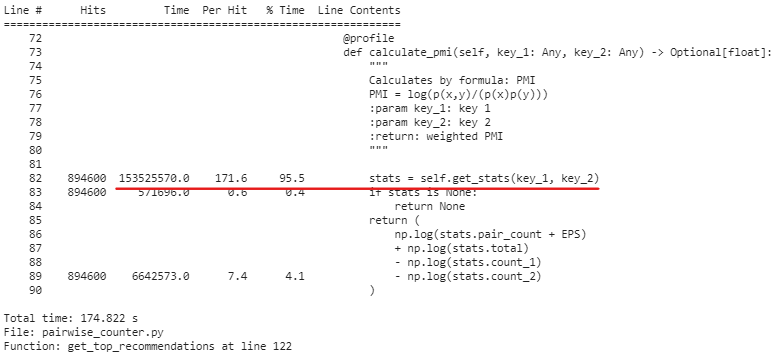

Видно, что метод ```counts_matrix(..)``` отрабатывает большое время. Посмотрим, что внутри.

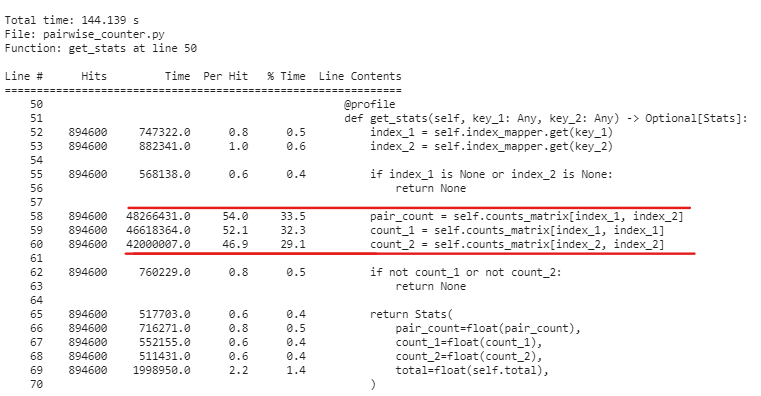

**Узкое место найдено!**

На картинке видно, что проблема в ```counts_matrix[..]```. Получается, что основная часть времени уходит просто на обращение к элементам матрицы по индексу.

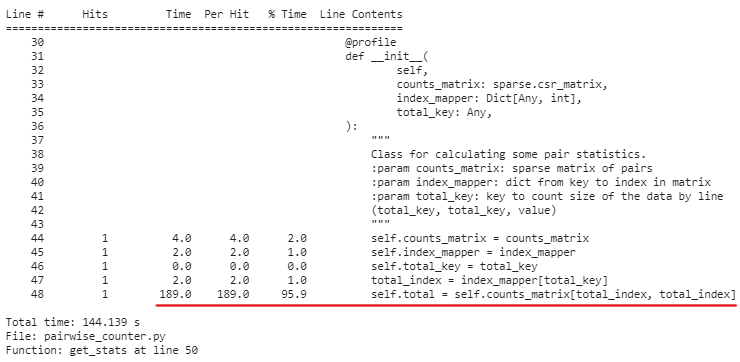


In [ ]:
pairwise_counter['counts_matrix']

## Оптимизация

Давайте попробуем оптимизировать алгоритм, используя все преимущества формата ```csr_matrix```.

TODO: Написать что сделано по пунктам и прикрепить скриншоты 
-
-
-

**Примечания к алгоритму.** 

Рекомендации не должны содержать пары товаров вида: `(key_1, key_1)`. Чтобы не учитывать их, будем брать срез `[-MAX_TOP_CANDIDATES-1:-1]` вместо среза `[-MAX_TOP_CANDIDATES:]`. Это верно, потому что "weighted PMI" наибольший именно 
для такой пары и значения в массие отсортированы по возрастанию.

In [ ]:
EPS = 1e-100
MAX_TOP_CANDIDATES: int = 10
most_co_occurring_products: tp.Dict[str, tp.List[str]] = dict()

i = 0
for key_1 in tqdm(product_ids, desc='outer loop'):
    index_1 = pairwise_counter.index_mapper.get(key_1)

    pair_counts = pairwise_counter.counts_matrix.getrow(i).toarray()[0].ravel()
    count_1 = pairwise_counter.counts_diagonal[index_1]

    pmis_row = np.log(pair_counts + EPS) + np.log(pairwise_counter.total) \
        - np.log(count_1) - np.log(pairwise_counter.counts_diagonal)
    
    top_candidates_indices = pmis_row.argsort()[-MAX_TOP_CANDIDATES-1:-1][::-1]
    most_co_occurring_products[key_1] = list(product_ids[top_candidates_indices])
    i += 1

In [ ]:
with open('/content/drive/MyDrive/Sber DS School/HW2/data/most_co_occurring_products11.txt', 'w') as outfile:
    json.dump(most_co_occurring_products, outfile)

## Профилирование оптимизированного алгоритма

In [ ]:
!pip install line_profiler
%load_ext line_profiler
%load_ext autoreload
%autoreload 4

In [ ]:
!kernprof -l -v pairwise_counter300.py

outer loop: 100% 8947/8947 [00:12<00:00, 696.00it/s]
Wrote profile results to pairwise_counter300.py.lprof
Timer unit: 1e-06 s

Total time: 0.000482 s
File: pairwise_counter300.py
Function: __init__ at line 30

Line #      Hits         Time  Per Hit   % Time  Line Contents
    30                                               @profile
    31                                               def __init__(
    32                                                       self,
    33                                                       counts_matrix: sparse.csr_matrix,
    34                                                       # Диагональ матрицы, вынесенная в отдельный numpy массив.
    35                                                       counts_diagonal: np.array,
    36                                                       index_mapper: Dict[Any, int],
    37                                                       total_key: Any,
    38                                               ):
    

In [ ]:
!pip install memory_profiler

In [ ]:
!python -m memory_profiler pairwise_counter300.py

outer loop: 100% 8947/8947 [00:22<00:00, 402.36it/s]
Filename: pairwise_counter200.py

Line #    Mem usage    Increment  Occurences   Line Contents
    30  542.590 MiB  542.590 MiB           1       @profile
    31                                             def __init__(
    32                                                     self,
    33                                                     counts_matrix: sparse.csr_matrix,
    34                                                     # Диагональ матрицы, вынесенная в отдельный numpy массив.
    35                                                     counts_diagonal: np.array,
    36                                                     index_mapper: Dict[Any, int],
    37                                                     total_key: Any,
    38                                             ):
    39                                                 """
    40                                                 Class for calculating some pair st

In [ ]:
%%writefile pairwise_counter300.py
from typing import Tuple, Iterable, Any, Dict, Optional, NamedTuple

import numpy as np

from scipy import sparse

import collections
import json
import typing as tp

from tqdm.auto import tqdm

# from pairwise_counter import PairwiseCounter


# need for log(0) where pair_count = 0
# do not affect results
EPS = 1e-100


class Stats(NamedTuple):
    pair_count: float
    count_1: float
    count_2: float
    total: float


class PairwiseCounter:

    @profile
    def __init__(
            self,
            counts_matrix: sparse.csr_matrix,
            # Диагональ матрицы, вынесенная в отдельный numpy массив.
            counts_diagonal: np.array,
            index_mapper: Dict[Any, int],
            total_key: Any,
    ):
        """
        Class for calculating some pair statistics.
        :param counts_matrix: sparse matrix of pairs
        :param index_mapper: dict from key to index in matrix
        :param total_key: key to count size of the data by line
        (total_key, total_key, value)
        """
        self.counts_matrix = counts_matrix
        self.counts_diagonal = counts_diagonal
        self.index_mapper = index_mapper
        self.total_key = total_key
        total_index = index_mapper[total_key]
        self.total = self.counts_matrix[total_index, total_index]

    @profile
    def get_stats(self, key_1: Any, key_2: Any) -> Optional[Stats]:
        index_1 = self.index_mapper.get(key_1)
        index_2 = self.index_mapper.get(key_2)

        if index_1 is None or index_2 is None:
            return None

        pair_count = self.counts_matrix[index_1, index_2]
        count_1 = self.counts_diagonal[index_1]
        count_2 = self.counts_diagonal[index_2]

        if not count_1 or not count_2:
            return None

        return Stats(
            pair_count=float(pair_count),
            count_1=float(count_1), 
            count_2=float(count_2), 
            total=float(self.total),
        )

    @profile
    def calculate_pmi(self, key_1: Any, key_2: Any) -> Optional[float]:
        """
        Calculates by formula: PMI
        PMI = log(p(x,y)/(p(x)p(y)))
        :param key_1: key 1
        :param key_2: key 2
        :return: weighted PMI
        """

        stats = self.get_stats(key_1, key_2)
        if stats is None:
            return None
        return (
            np.log(stats.pair_count + EPS)
            + np.log(stats.total)
            - np.log(stats.count_1)
            - np.log(stats.count_2)
        )

    def to_dict(self) -> Dict[str, Any]:
        counts_matrix_dict = dict(
            data=self.counts_matrix.data.tolist(),
            indices=self.counts_matrix.indices.tolist(),
            indptr=self.counts_matrix.indptr.tolist(),
            shape=self.counts_matrix.shape,
        )
        return dict(
            counts_matrix=counts_matrix_dict,
            index_mapper=self.index_mapper,
            total_key=self.total_key,
        )

    @staticmethod
    def from_dict(params_dict: Dict[str, Any]):
        counts_matrix = sparse.csr_matrix(
            (
                params_dict['counts_matrix']['data'],
                params_dict['counts_matrix']['indices'],
                params_dict['counts_matrix']['indptr'],
            ),
            shape=params_dict['counts_matrix']['shape'],
        )
        return PairwiseCounter(
            counts_matrix=counts_matrix,
            counts_diagonal=counts_matrix.diagonal(),
            index_mapper=params_dict['index_mapper'],
            total_key=params_dict['total_key'],
        )
        
    
@profile
def get_top_recommendations():
  with open('/content/drive/MyDrive/Sber DS School/HW2/data/product_pairwise_counter.txt', 'r', encoding='utf8') as infile:
    pairwise_counter = PairwiseCounter.from_dict(json.load(infile))

  product_ids = np.array([
      product_id 
      for product_id in pairwise_counter.index_mapper.keys() 
      if product_id != pairwise_counter.total_key
  ])
  

  # need for log(0) where pair_count = 0
  # do not affect results
  EPS = 1e-100
  MAX_TOP_CANDIDATES: int = 10
  most_co_occurring_products: tp.Dict[str, tp.List[str]] = dict()

  i = 0
  for key_1 in tqdm(product_ids, desc='outer loop'):
      index_1 = pairwise_counter.index_mapper.get(key_1)
  
      pair_counts = pairwise_counter.counts_matrix.getrow(i).toarray()[0].ravel()
      count_1 = pairwise_counter.counts_diagonal[index_1]
  
      pmis_row = np.log(pair_counts + EPS) + np.log(pairwise_counter.total) \
          - np.log(count_1) - np.log(pairwise_counter.counts_diagonal)
      
      top_candidates_indices = pmis_row.argsort()[-MAX_TOP_CANDIDATES-1:-1][::-1]
      most_co_occurring_products[key_1] = list(product_ids[top_candidates_indices])
      i += 1


if __name__ == '__main__':
  get_top_recommendations()

Overwriting pairwise_counter300.py
